# Problem Set 2

#### Abram and Higbee - IO 2, 2021

### Set up environment

In [293]:
# Set wd
pwd()
dir = "/Users/JoshuaHigbee/Box/2. Second Year/2. Winter Quarter - 2021/" *
      "Industrial Organization II - Hortacsu/Problem Sets/Problem Set 2/";
cd(dir);

# Set up packages (must have pre-loaded)
using CSV, DataFrames, Random, Distributions, LinearAlgebra,
      LatexPrint, StatsBase, Plots, SpecialFunctions
using Optim, ForwardDiff, PyCall, ShiftedArrays, StatsPlots

# Set seed
Random.seed!(12345);

# Set column view
ENV["COLUMNS"]=500;

<br><br><br><br>

## QUESTION 1.3

### 1.3.2 - Bayes-Nash Equilibria

Given the shape of the best response functions, and the fact that there are two players, there are at most 3 equilibria for any value of $x$.  First, we verify this using a grid search over parameters, then we use Newton's method to speed up the process and achieve more precision.

##### Grid search for intersections

In [3]:
# Search grid of starting values for equilibria
fxp_eq_grid = (0:1e7) / 1e7

# BR function (vector)
br_eq_vec = function(; α, δ, x, p)
    return exp.(Ref(α*x) .- δ*p) ./ (Ref(1) .+ exp.(Ref(α*x) .- δ*p))
end

# Check equilibria
check_eq_vec = function(; α, δ, x)
    eq_check = DataFrame(p = fxp_eq_grid)
    eq_check.p1 = br_eq_vec(α=α, δ=δ, x=x, p=br_eq_vec(α=α, δ=δ, x=x, p=eq_check.p))
    eq_check.diff = (abs.(eq_check.p .- eq_check.p1) .> 1e-7)
    p1_eq = unique(round.(eq_check[eq_check.diff .== 0, :p], digits=3))
    return hcat(round.(p1_eq, digits=3), round.(br_eq_vec(α=α, δ=δ, x=x, p=p1_eq), digits=3))
end

# Check equilibria for each combination of parameters and x values
println(check_eq_vec(α=1, δ=1, x=1))
println(check_eq_vec(α=1, δ=1, x=2))
println(check_eq_vec(α=3, δ=6, x=1))
println(check_eq_vec(α=3, δ=6, x=2))

[0.599 0.599]
[0.773 0.773]
[0.071 0.929; 0.5 0.5; 0.929 0.071]
[0.712 0.849; 0.785 0.784; 0.849 0.712]


##### Newton's method

In [9]:
# BR function (vector)
br_eq_vec = function(; α, δ, x, p)
    return (exp.(α*x .- δ*p) ./ (Ref(1) .+ exp.(α*x .- δ*p)))
end

# FXP function
fxp_eq_f = function(; α, δ, x, p)
    return p .- reverse(br_eq_vec(α=α, δ=δ, x=x, p=p))
end

# dFXP function
fxp_eq_df = function(; α, δ, x, p)
    dp1dp2 = -(δ*exp.(δ*p[2] .+ α*x))./(exp.(δ*p[2]) .+ exp.(α*x))^2
    dp2dp1 = -(δ*exp.(δ*p[1] .+ α*x))./(exp.(δ*p[1]) .+ exp.(α*x))^2
    return I - [0 dp1dp2; dp2dp1 0]
end

# Newton function
fxp_eq = function(; α, δ, x, p)
    diff = 1; p0=p; p1=p; iter=1
    while diff > 1e-6 && iter < 20
        p1 = p0 .- fxp_eq_df.(α=α, δ=δ, x=x, p=p0)\fxp_eq_f.(α=α, δ=δ, x=x, p=p0)
        diff = maximum(abs.(p1 .- p0))
        p0 = p1; iter=iter+1
    end
    return p1
end


# Save strategy values for use later
θ_vec = [[1,1], [3,6]]
eq_vec = Array{Array{Float64}}(undef, 2, 2)
for x in 1:2
    for i in 1:2
        h_1 = fxp_eq(α=θ_vec[i][1], δ=θ_vec[i][2], x=x, p=[1; 0]) # 1 plays high prob
        sym = fxp_eq(α=θ_vec[i][1], δ=θ_vec[i][2], x=x, p=[0.5; 0.5]) # Symmetric
        l_1 = fxp_eq(α=θ_vec[i][1], δ=θ_vec[i][2], x=x, p=[0; 1]) # 2 plays low prob
        eq_vec[x,i] = [h_1 sym l_1]'
    end
end

# x=1
println(round.(eq_vec[1,1], digits=3)) # α=1, δ=1
println(round.(eq_vec[1,2], digits=3)) # α=3, δ=6

# x=2
println(round.(eq_vec[2,1], digits=3)) # α=1, δ=1
println(round.(eq_vec[2,2], digits=3)) # α=3, δ=6

[0.599 0.599; 0.599 0.599; 0.599 0.599]
[0.929 0.071; 0.5 0.5; 0.071 0.929]
[0.773 0.773; 0.773 0.773; 0.773 0.773]
[0.849 0.712; 0.785 0.785; 0.712 0.849]


<br><br><br><br><br>

### 1.3.3 - Symetric Strategy Estimation

We now use the Newton's method approach to estimate the strategies within the maximum likelihood estimation.

##### Set up simulation data

# DO WE GENERATE DATA ASSUMING THEY ONLY CHOOSE SYMMETRIC EQUILIBRIA?

In [10]:
# Set up parameters
α=3; δ=6;
T=1000; S=50;

# Create simulation data
dt = DataFrame(t = repeat(1:T, outer = S), s = repeat(1:S, inner = T))
dt.x = repeat(rand(Binomial(1,0.5), T) .+ Ref(1.0), outer = S)
dt.ϵ_1 = rand(Logistic(0,1),S*T)
dt.ϵ_2 = rand(Logistic(0,1),S*T)
dt.y_1 = 1.0*(dt.x .== 1.0).*(α*dt.x .- δ*0.5 .+ dt.ϵ_1 .>= 0) .+ 
            1.0*(dt.x .== 2.0).*(α*dt.x .- δ*0.785 .+ dt.ϵ_1 .>= 0)
dt.y_2 = 1.0*(dt.x .== 1.0).*(α*dt.x .- δ*0.5 .+ dt.ϵ_2 .>= 0) .+ 
            1.0*(dt.x .== 2.0).*(α*dt.x .- δ*0.785 .+ dt.ϵ_2 .>= 0);

##### Write functions for MLE

In [390]:
# Log-Likelihood individual term - function of the other player's strategy p
ll_i = function(; α, δ, x, p, y)
    y1 = y.*(α.*x .- δ.*p .- log.(Ref(1.0) .+ exp.(α.*x .- δ.*p)))
    y0 = (Ref(1.0).-y) .* log.(Ref(1.0) .- exp.(α.*x .- δ.*p)./
            (Ref(1.0) .+ exp.(α.*x .- δ.*p)))
    return y1 + y0
end

# Log-Likelihood
ll_all = function(; α, δ, p0=[0.5, 0.5])
    dt_temp = copy(dt_sim); dt_temp.p̂1 = Ref(-1.0); dt_temp.p̂2 = Ref(-1.0)
    for r in 1:nrow(dt_temp)
        row = dt_temp[r,:]
        p̂ = fxp_eq(α=α, δ=δ, x=row.x, p=p0)
        dt_temp[r, :p̂1] = p̂[1]
        dt_temp[r, :p̂2] = p̂[2]
    end
    prob1 = ll_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2, y=dt_temp.y_1)
    prob2 = ll_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1, y=dt_temp.y_2)
    prob = prob1 .+ prob2
    return sum(prob)
end

# Log-Likelihood to pass to Optim
ll_optim = function(θ)
    α=θ[1];δ=θ[2]
    return -1.0 .* ll_all(α=α, δ=δ, p0=[0.5, 0.5])
end

# Log-Likelihood individual term - gradient
ll_grad_i = function(; α, δ, x, p, y)
    dll_α1 = y .* x .* exp.(δ.*p) ./ (exp.(α.*x) .+ exp.(δ.*p))
    dll_δ1 = -y .* p .* exp.(δ.*p) ./ (exp.(α.*x) .+ exp.(δ.*p))
    dll_α0 = (y .- Ref(1.0)) .* x .* exp.(α.*x) ./ (exp.(α.*x) .+ exp.(δ.*p))
    dll_δ0 = -(y .- Ref(1.0)) .* p .* exp.(α.*x) ./ (exp.(α.*x) .+ exp.(δ.*p))
    return [(dll_α1 .+ dll_α0) (dll_δ1 .+ dll_δ0)]
end

# Log-Likelihood - gradient
ll_grad_all = function(; α, δ, p0=[0.5, 0.5])
    dt_temp = copy(dt_sim); dt_temp.p̂1 = Ref(-1.0); dt_temp.p̂2 = Ref(-1.0)
    for r in 1:nrow(dt_temp)
        row = dt_temp[r,:]
        p̂ = fxp_eq(α=α, δ=δ, x=row.x, p=p0)
        dt_temp[r, :p̂1] = p̂[1]
        dt_temp[r, :p̂2] = p̂[2]
    end
    dll_1 = ll_grad_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1, y=dt_temp.y_1)
    dll_2 = ll_grad_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2, y=dt_temp.y_2)
    dll_t = dll_1 .+ dll_2
    dll = mean(dll_t, dims=1)
    return dll
end

# Log-Likelihood gradient to pass to Optim
ll_grad_optim = function(G, θ)
    α=θ[1];δ=θ[2]
    ll_g = -1.0 .* ll_grad_all(α=α, δ=δ, p0=[0.5, 0.5])
    G[1] = ll_g[1]
    G[2] = ll_g[2]
end;

##### Test optimization (with and without gradient)

In [391]:
dt_sim = copy(dt[dt[:s].==1,:]);

@time optimum = optimize(ll_optim,[1.0,1.0])
println(optimum.minimizer)

@time optimum_g = optimize(ll_optim, ll_grad_optim, [1.0, 1.0], BFGS())
println(optimum_g.minimizer)

  3.453759 seconds (18.01 M allocations: 959.353 MiB, 7.54% gc time)
[3.18119842443958, 6.342325724594184]
  2.497600 seconds (9.54 M allocations: 504.659 MiB, 5.38% gc time)
[3.1810950194260643, 6.3420692716961735]


##### Estimate maximum likelihood

In [392]:
# Loop over simulation draws
params_sim = DataFrame(α= fill(0.0, S), δ= fill(0.0, S))
print("Iters: ")
for s in 1:nrow(params_sim)
    dt_sim = copy(dt[dt[:s].==s,:]);
    # res = optimize(ll_optim, [1.0, 1.0])
    res = optimize(ll_optim, ll_grad_optim, [1.0,1.0], BFGS())
    params_sim[s, [:α, :δ]] = res.minimizer
    print(" " * string(s))
end
params_sim

println(" "); println(" ")
println("Mean α is " * string(mean(params_sim.α)))
println("Mean δ is " * string(mean(params_sim.δ)))

Iters:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
 
Mean α is 2.978342959908431
Mean δ is 5.920328948417473


##### Plot histograms for analysis

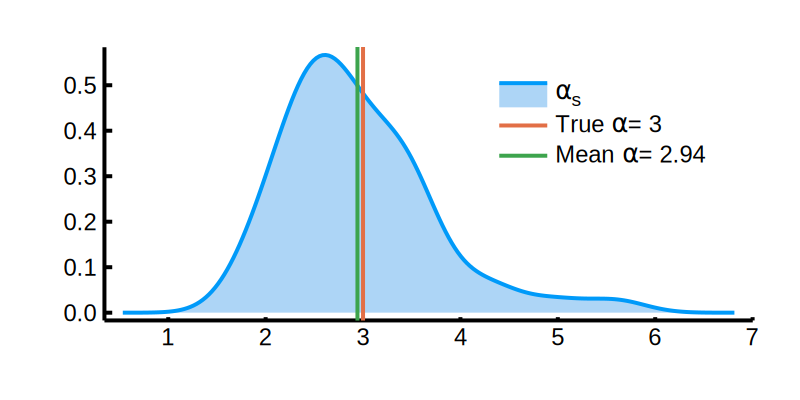

In [329]:
# α
fig = density(params_sim[:, :α], fill=(0, .5,:steelblue2), lab="\\alpha_s",  
        linecolor=:match, linewidth=1)
plot!(collect(α), seriestype="vline", 
        lab="True \\alpha = " * string(α), 
        linewidth=1)
plot!(collect(mean(params_sim.α)), seriestype="vline", 
        lab="Mean \\alpha = " * string(round(mean(params_sim.α), digits=2)),
        linewidth=1, legendfont=font(4), xtickfont=font(4), ytickfont=font(4),
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("1_3_3_alpha.png")
fig

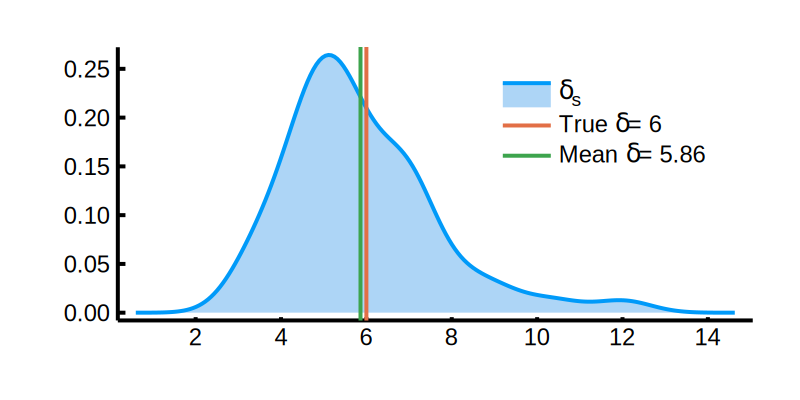

In [331]:
# δ
fig = density(params_sim[:, :δ], fill=(0, .5,:steelblue2), lab="\\delta_s",  
        linecolor=:match, linewidth=1)
plot!(collect(δ), seriestype="vline", 
        lab="True \\delta = " * string(δ), 
        linewidth=1)
plot!(collect(mean(params_sim.δ)), seriestype="vline", 
        lab="Mean \\delta = " * string(round(mean(params_sim.δ), digits=2)),
        linewidth=1, legendfont=font(4), xtickfont=font(4), ytickfont=font(4),
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("1_3_3_delta.png");
fig

<br><br><br><br><br>

### 1.3.4 - All-Strategies Estimation

We now allow the equilibria to be chosen randomly (the firms know the strategy that is chosen, but we do not).

##### Generate data

In [408]:
# Model k ∈ {1,...,K} with prob exp(k/2)
eq_opts = eq_vec[:,2]
eq_probs = exp.([1, 2, 3]./2) ./ sum(exp.([1, 2, 3]./2))

# Function to map x, equilibrium, and player number to other player's strat
eq_map = function(x, eq, player)
    x = convert(Int64, x)
    return eq_opts[x][eq,player]
end

# Set up parameters
α=3; δ=6
T=1000; S=50

# Create simulation data
dt = DataFrame(t = repeat(1:T, outer = S), s = repeat(1:S, inner = T))
dt.x = repeat(rand(Binomial(1,0.5), T) .+ Ref(1.0), outer = S)
dt.ϵ_1 = rand(Logistic(0,1), S*T)
dt.ϵ_2 = rand(Logistic(0,1), S*T)
dt.eq = rand(Categorical(eq_probs), S*T)
dt.y_1 = 1.0.*(α*dt.x .- δ*eq_map.(dt.x, dt.eq, 2) .+ dt.ϵ_1 .>= 0)
dt.y_2 = 1.0.*(α*dt.x .- δ*eq_map.(dt.x, dt.eq, 1) .+ dt.ϵ_1 .>= 0);

First, we can check how the MLE estimator from the previous section performs:

In [409]:
# Loop over simulation draws
params_sim = DataFrame(α= fill(0.0, S), δ= fill(0.0, S))
print("Iters: ")
for s in 1:nrow(params_sim)
    dt_sim = copy(dt[dt[:s].==s,:]);
    # res = optimize(ll_optim, [1.0, 1.0])
    res = optimize(ll_optim, ll_grad_optim, [1.0,1.0], BFGS())
    params_sim[s, [:α, :δ]] = res.minimizer
    print(" " * string(s))
end
params_sim

println(" ")
println("Mean α is " * string(mean(params_sim.α)))
println("Mean δ is " * string(mean(params_sim.δ)))

Iters:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Mean α is 3.107432914229756
Mean δ is 6.310282024252246


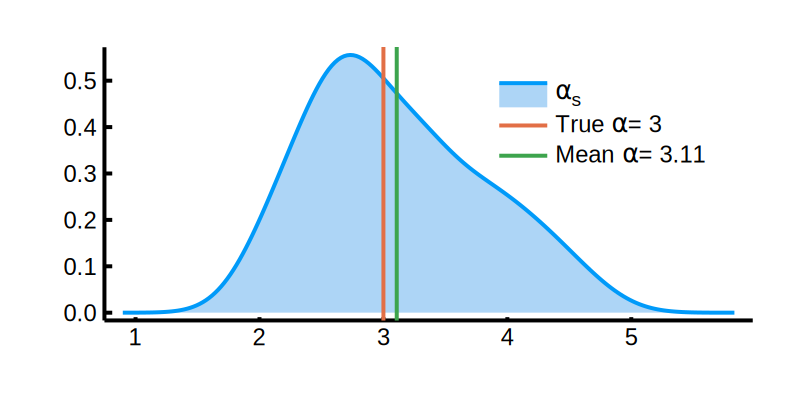

In [410]:
# α
fig = density(params_sim[:, :α], fill=(0, .5,:steelblue2), lab="\\alpha_s",  
        linecolor=:match, linewidth=1)
plot!(collect(α), seriestype="vline", 
        lab="True \\alpha = " * string(α), 
        linewidth=1)
plot!(collect(mean(params_sim.α)), seriestype="vline", 
        lab="Mean \\alpha = " * string(round(mean(params_sim.α), digits=2)),
        linewidth=1, legendfont=font(4), xtickfont=font(4), ytickfont=font(4),
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("1_3_4sym_alpha.png")
fig

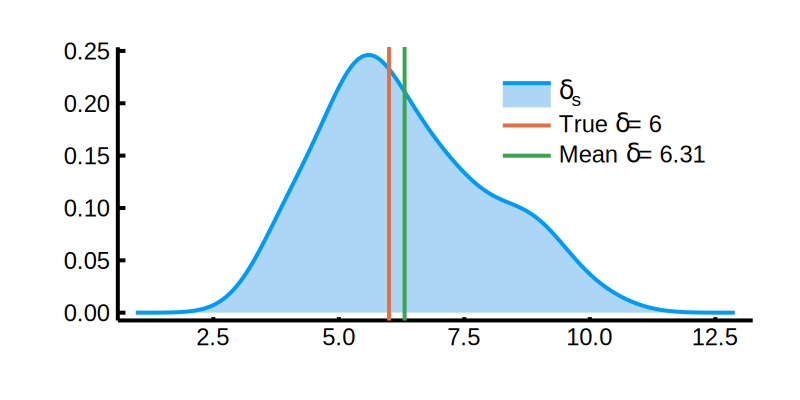

In [411]:
# δ
fig = density(params_sim[:, :δ], fill=(0, .5,:steelblue2), lab="\\delta_s",  
        linecolor=:match, linewidth=1)
plot!(collect(δ), seriestype="vline", 
        lab="True \\delta = " * string(δ), 
        linewidth=1)
plot!(collect(mean(params_sim.δ)), seriestype="vline", 
        lab="Mean \\delta = " * string(round(mean(params_sim.δ), digits=2)),
        linewidth=1, legendfont=font(4), xtickfont=font(4), ytickfont=font(4),
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("1_3_4sym_delta.png");
fig

##### Estimating with random equilibria

# EM-ALGORITHM?

We consider mixture weights $\omega_i$ as auxiliary parameters for $i \in \{1,2,3\}$

##### Functions for log-likelihood evaluation to determine convergence

In [420]:
# Re-weight to ensure bounds work
ω_bound(ω,i) = exp(ω[i]) / (sum(exp.(ω)))

ω_bound (generic function with 1 method)

In [466]:
# Likelihood individual term
l_mix_i = function(; α, δ, x, p, y)
    y1 = br_eq_vec(α=α, δ=δ, x=x, p=p).^y
    y0 = (Ref(1.0) .- br_eq_vec(α=α, δ=δ, x=x, p=p)).^(Ref(1.0) .- y)
    return y1 .* y0
end

# Log-Likelihood function for mixture
ll_mix_all = function(; α, δ, ω=[1/3, 1/3, 1/3])
    dt_temp = copy(dt_sim); 
    dt_temp.p̂1_1 = Ref(-1.0); dt_temp.p̂1_2 = Ref(-1.0); dt_temp.p̂1_3 = Ref(-1.0); 
    dt_temp.p̂2_1 = Ref(-1.0); dt_temp.p̂2_2 = Ref(-1.0); dt_temp.p̂2_3 = Ref(-1.0)
    for r in 1:nrow(dt_temp)
        row = dt_temp[r,:]
        p̂_1 = fxp_eq(α=α, δ=δ, x=row.x, p=[1, 0])
        p̂_2 = fxp_eq(α=α, δ=δ, x=row.x, p=[0.5, 0.5])
        p̂_3 = fxp_eq(α=α, δ=δ, x=row.x, p=[0, 1])
        dt_temp[r, :p̂1_1] = p̂_1[1]; dt_temp[r, :p̂1_2] = p̂_2[1]; dt_temp[r, :p̂1_3] = p̂_3[1]
        dt_temp[r, :p̂2_1] = p̂_1[2]; dt_temp[r, :p̂2_2] = p̂_2[2]; dt_temp[r, :p̂2_3] = p̂_3[2]
    end
    prob1 = ω_bound(ω,1).*l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2_1, y=dt_temp.y_1) .+
            ω_bound(ω,2).*l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2_2, y=dt_temp.y_1) .+
            ω_bound(ω,3).*l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2_3, y=dt_temp.y_1)
    prob2 = ω_bound(ω,1).*l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1_1, y=dt_temp.y_2) .+
            ω_bound(ω,2).*l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1_2, y=dt_temp.y_2) .+
            ω_bound(ω,3).*l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1_3, y=dt_temp.y_2)
    prob = log.(prob1) .+ log.(prob2)
    return sum(prob)
end

# Adapt Log-Likelihood to pass to Optim
ll_mix_optim = function(θ)
    α=θ[1]; δ=θ[2]; ω=θ[3:5]
    return -1.0 .* ll_mix_all(α=α, δ=δ, ω=ω)
end;

We now check to make sure this is working properly for some values of $\theta$.

In [467]:
dt_sim = copy(dt[dt[:s].==1,:]);
ll_mix_optim([3.0,6.0,1/3,1/3,1/3])

1226.9711525927648

In [468]:
ll_mix_optim([3.0,6.0,0.2,0.3,0.5])

1204.9153642322472

In [469]:
ll_mix_optim([0.0,0.0,0.2,0.3,0.5])

1386.2943611198923

##### Functions for EM algorithm to estimate the parameters

In [479]:
# Expected log-likelihood function
E_ll_mix_all = function(; α, δ, ω, z_weights)
    dt_temp = copy(dt_sim); 
    dt_temp.p̂1_1 = Ref(-1.0); dt_temp.p̂1_2 = Ref(-1.0); dt_temp.p̂1_3 = Ref(-1.0); 
    dt_temp.p̂2_1 = Ref(-1.0); dt_temp.p̂2_2 = Ref(-1.0); dt_temp.p̂2_3 = Ref(-1.0)
    for r in 1:nrow(dt_temp)
        row = dt_temp[r,:]
        p̂_1 = fxp_eq(α=α, δ=δ, x=row.x, p=[1, 0])
        p̂_2 = fxp_eq(α=α, δ=δ, x=row.x, p=[0.5, 0.5])
        p̂_3 = fxp_eq(α=α, δ=δ, x=row.x, p=[0, 1])
        dt_temp[r, :p̂1_1] = p̂_1[1]; dt_temp[r, :p̂1_2] = p̂_2[1]; dt_temp[r, :p̂1_3] = p̂_3[1]
        dt_temp[r, :p̂2_1] = p̂_1[2]; dt_temp[r, :p̂2_2] = p̂_2[2]; dt_temp[r, :p̂2_3] = p̂_3[2]
    end
    prob1 = z_weights[:,1].*(log.(ω_bound(ω,1)) .+ 
                ll_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2_1, y=dt_temp.y_1)) .+
            z_weights[:,2].*(log.(ω_bound(ω,2)) .+ 
                ll_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2_2, y=dt_temp.y_1)) .+
            z_weights[:,3].*(log.(ω_bound(ω,3)) .+ 
                ll_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2_3, y=dt_temp.y_1))
    prob2 = z_weights[:,1].*(log.(ω_bound(ω,1)) .+ 
                ll_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1_1, y=dt_temp.y_2)) .+
            z_weights[:,2].*(log.(ω_bound(ω,2)) .+ 
                ll_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1_2, y=dt_temp.y_2)) .+
            z_weights[:,3].*(log.(ω_bound(ω,3)) .+ 
                ll_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1_3, y=dt_temp.y_2))
    prob = prob1 .+ prob2
    return sum(prob)
end


# EM iteration
em_step = function(; θ)
    α=θ[1]; δ=θ[2]; ω=θ[3:5];
    dt_temp = copy(dt_sim); 
    
    
    # Likelihood of each observation's equilibrium given parameter values (E step)
    dt_temp.p̂1_1 = Ref(-1.0); dt_temp.p̂1_2 = Ref(-1.0); dt_temp.p̂1_3 = Ref(-1.0); 
    dt_temp.p̂2_1 = Ref(-1.0); dt_temp.p̂2_2 = Ref(-1.0); dt_temp.p̂2_3 = Ref(-1.0)
    for r in 1:nrow(dt_temp)
        row = dt_temp[r,:]
        p̂_1 = fxp_eq(α=α, δ=δ, x=row.x, p=[1, 0])
        p̂_2 = fxp_eq(α=α, δ=δ, x=row.x, p=[0.5, 0.5])
        p̂_3 = fxp_eq(α=α, δ=δ, x=row.x, p=[0, 1])
        dt_temp[r, :p̂1_1] = p̂_1[1]; dt_temp[r, :p̂1_2] = p̂_2[1]; dt_temp[r, :p̂1_3] = p̂_3[1]
        dt_temp[r, :p̂2_1] = p̂_1[2]; dt_temp[r, :p̂2_2] = p̂_2[2]; dt_temp[r, :p̂2_3] = p̂_3[2]
    end
    prob_eq1 =  ω_bound(ω,1).*l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2_1, y=dt_temp.y_1) .*
                    l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1_1, y=dt_temp.y_2)
    prob_eq2 =  ω_bound(ω,2).*l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2_2, y=dt_temp.y_1) .*
                    l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1_2, y=dt_temp.y_2)
    prob_eq3 =  ω_bound(ω,3).*l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂2_3, y=dt_temp.y_1) .*
                    l_mix_i(α=α, δ=δ, x=dt_temp.x, p=dt_temp.p̂1_3, y=dt_temp.y_2)
    probs = hcat(prob_eq1, prob_eq2, prob_eq3)
    p_rowsum = sum(probs, dims=2)
    z_weights = probs ./ hcat(p_rowsum, p_rowsum, p_rowsum)
    
    
    # Maximize likelihood given weights (M step)
        # Adapt E[Log-Likelihood] to pass to Optim
        E_ll_mix_optim = function(θ)
            α=θ[1]; δ=θ[2]; ω=θ[3:5]
            return -1.0 .* E_ll_mix_all(α=α, δ=δ, ω=ω, z_weights=z_weights)
        end;
    optimum_g = optimize(E_ll_mix_optim, θ, Optim.Options(show_trace = false, iterations=100))
    θ = optimum_g.minimizer
    θ[3:5] = exp.(θ[3:5]) / (sum(exp.(θ[3:5])))
    return θ
end


# Implement EM algorithm
em_alg = function(; θ_0)
    diff = 1; ll_0 = 0;
    while diff > 1e-3
        θ_1 = em_step(θ=θ_0)
        ll_1 = ll_mix_optim(θ_1)
        diff = abs(ll_1 - ll_0)
        θ_0 = θ_1; ll_0 = ll_1
        println("Log-likelihood is " * string(round(ll_1, digits=4)))
        println("    θ is " * string(round.(θ_0, digits=4)))
    end
    return θ_0
end

#578 (generic function with 1 method)

In [480]:
em_alg(θ_0 = [1.0,1.0,1/3,1/3,1/3])

Log-likelihood is 1208.6428
    θ is [2.2367, 4.0112, 0.3333, 0.3339, 0.3328]
Log-likelihood is 1208.6388
    θ is [2.2412, 4.0137, 0.3335, 0.3333, 0.3332]
Log-likelihood is 1208.6388
    θ is [2.2412, 4.0137, 0.3334, 0.3333, 0.3333]


5-element Array{Float64,1}:
 2.2412485477177952
 4.013714363540298
 0.33338824528861744
 0.33333705710394707
 0.3332746976074356

## Some concerns about how the EM is currently running:

- LL is roughly where it should be (see above - approx 1204.9) but weights seem off (should be about 0.2, 0.3, 0.5)
- Updating seems to stop too soon (even with large tolerance) - might be because of z_weights part? At least the parameters are approaching where they should be (instead of going negative as before)

In [476]:
dt_sim = copy(dt[dt[:s].==5,:]);
em_step(θ=[1.0,1.0,1/3,1/3,1/3])

Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     3.421587e+03     3.554271e+01
 * time: 0.00022292137145996094
     1     3.421587e+03     1.304784e+01
 * time: 0.24463605880737305
     2     3.421587e+03     4.789114e+00
 * time: 0.4795041084289551
     3     3.421587e+03     3.349012e+00
 * time: 0.85555100440979
     4     3.421587e+03     3.274629e+00
 * time: 1.2272140979766846
     5     3.421587e+03     2.747347e+00
 * time: 1.4884459972381592
     6     3.421587e+03     1.334203e+00
 * time: 1.8178889751434326
     7     3.421587e+03     9.701891e-01
 * time: 2.1338040828704834
     8     3.420881e+03     1.366865e+00
 * time: 2.501599073410034
     9     3.419495e+03     1.269391e+00
 * time: 2.8829898834228516
    10     3.419495e+03     1.053424e+00
 * time: 3.433382987976074
    11     3.419495e+03     6.266349e-01
 * time: 3.891077995300293
    12     3.419495e+03     9.017815e-01
 * time: 4.279191970825195
    13     3.418470e

5-element Array{Float64,1}:
 2.2367493649117023
 4.011212638648408
 0.3333032009819218
 0.33392129759682476
 0.3327755014212534

<br><br><br><br>

### 1.3.5 More unobserved heterogeneity

In [84]:
# Model k ∈ {1,...,K} with prob exp(k/2)
eq_opts = eq_vec[:,2]

# Function to map x, equilibrium, and player number to other player's strat
eq_map = function(x, eq, player)
    x = convert(Int64, x)
    return eq_opts[x][eq,player]
end

# Set up parameters
α=3; δ=6
T=1000; S=50

# Create simulation data
dt = DataFrame(t = repeat(1:T, outer = S), s = repeat(1:S, inner = T))
dt.x = repeat(rand(Binomial(1,0.5), T) .+ Ref(1.0), outer = S)
dt.ϵ_1 = rand(Logistic(0,1), S*T)
dt.ϵ_2 = rand(Logistic(0,1), S*T)
dt.eq = Ref(0)
for r in 1:nrow(dt)
    u_p = 1.0 ./(1.0 .+ dt[r,:x])
    num = [1.0, 2.0, 3.0] .+ repeat(1.0.* rand(Binomial(1, 0.5),1),3)
    eq_probs = exp.(num./2) ./ sum(exp.(num./2))
    dt.eq = rand(Categorical(eq_probs), 1)[1]
end
dt.y_1 = 1.0.*(α*dt.x .- δ*eq_map.(dt.x, dt.eq, 2) .+ dt.ϵ_1 .>= 0)
dt.y_2 = 1.0.*(α*dt.x .- δ*eq_map.(dt.x, dt.eq, 1) .+ dt.ϵ_1 .>= 0);

Now we estimate this with the same method as above:

<br><br><br><br>

## QUESTION 2.3

##### Read in data

In [226]:
data = CSV.read("psetTwo.csv", DataFrame);
println(names(data))
convert.(Float64, data.milage);

["milage"]


##### Define utility function

In [343]:
utility = function(; x, d, θ)
    if d == 0
        return -θ[1].*x .- θ[2].*(x./100).^2
    else
        return -θ[3]
    end
end;

<br><br>
### 1. Engine replacement

Generate dummy variable.

In [227]:
data.d = 1.0.*(data[:milage] .< lag(data[:milage]));
data[ismissing.(data[:d]),:d] = Ref(0.0);

<br><br>
### 3. Discretize state space and estimate transition probabilities

##### Discretize state space and generate state dummy variables

In [166]:
# Get summary statistics of milage
min_mile = minimum(data.milage)
max_mile = maximum(data.milage)
println(minimum(data.milage))
println(maximum(data.milage))

1
221


In [167]:
# Divide state space into K states
K = 21;

### Using constant step sizes

In [168]:
# k_step = (max_mile - min_mile)/K

# state_cols = fill(" ", K)
# for k in 1:K
#     k_min = min_mile + (k-1)*k_step
#     k_max = min_mile + k*k_step
#     data[!, "s_" * string(k)] = 1.0.*(k_min .≤ data.milage .≤ k_max)
#     state_cols[k] = "s_" * string(k)
# end

### Using (approximately) constant bin counts

In [237]:
k_q = nquantile(data.milage, K);
data.s_now = Ref(0)

state_cols = fill(" ", K)
last_state_cols = fill(" ", K)
for k in 1:K
    data[(k_q[k] .< data.milage .≤ k_q[k+1]) .| (data.milage .== 1), :s_now] = Ref(k)
end

## From here on, no dependence on how state chunks were set

In [238]:
data.s_prev = Ref(0)
for r in 2:nrow(data)
    data[r,:s_prev] = data[r-1,:s_now]
end

In [244]:
for k in 1:K
    data[!, "s_" * string(k)] = 1.0.*(data.s_now .== k)
    state_cols[k] = "s_" * string(k)
end
for k in 1:K
    data[!, "ls_" * string(k)] = 1.0.*(data.s_prev .== k)
    last_state_cols[k] = "ls_" * string(k)
end

##### Estimate conditional transition probabilities

Start with transition probability conditional on $d=1$.

In [280]:
# Estimate P_d1
P_d1 = reshape(fill(0.0,K*K), K, K);
for k in 1:K
    if nrow(data[(data[:d] .== 1) .& (data[:s_prev] .== k),:]) > 0
        row_k = mean(Matrix(data[(data.d .== 1) .& (data.s_prev .== k), state_cols]), dims=1)
        P_d1[k,:] = row_k
    end
end

In [286]:
round.(P_d1,digits=1)

21×21 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.3  0.3  0.3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.3  0.3  0.3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.5  0.5  0.0  0.0  0.0  0.0  

Now estimate transition probability conditional on $d=0$.

In [283]:
# Estimate P_d1
P_d0 = reshape(fill(0.0,K*K), K, K);
for k in 1:K
    if nrow(data[(data[:d] .== 0) .& (data[:s_prev] .== k),:]) > 0
        row_k = mean(Matrix(data[(data.d .== 0) .& (data.s_prev .== k), state_cols]), dims=1)
        P_d0[k,:] = row_k
    end
end

In [288]:
round.(P_d0,digits=1)

21×21 Array{Float64,2}:
 0.1  0.5  0.3  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.3  0.5  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.4  0.4  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.1  0.4  0.3  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.1  0.3  0.4  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.3  0.5  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.3  0.5  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.4  0.4  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.4  0.4  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  

<br><br>
### 3. Fixed-point solver with Rust's poly-algorithm

<br><br>
### 4. Compute Likelihood

<br><br>
### 5. Compute Likelihood gradient

<br><br>
### 6. Estimation

<br><br><br><br>

## QUESTION 2.3.2

### 3. Non-parametric estimation of CCPs

### 4. Sequential policy estimation

### 5. Solving estimator once

### 6. Solving estimator 10 times

<br><br><br><br>

## QUESTION 2.3.3

### 1. Forward simulation for value function

### 2. Hotz-Miller inversion

### 3. BBL loss function

### 4. Frequency estimator

### 5. Estimation